In [1]:
##############################################################################################################
# DESCRIPTION: 
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

class HyperParams:
    pass

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

IMG_PATH_TRAIN = IMG_PATH

hyperparams = HyperParams()
hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 400
hyperparams.BATCH_SIZE = 16

hyperparams.NUM_CHANNELS = 32
hyperparams.NUM_RES_BLOCKS = 5

hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0100_1000"
MODEL_NAME = "0100_1000-64-resnet-xxh-2"

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0898
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.3248

from tensorflow.keras.optimizers import Nadam
hyperparams.OPTIMIZER = Nadam(learning_rate=0.0001)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelD as train
import ReportsK as reports
import ResnetBatchE as model_factory

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5537435353073657926
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5722079232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17540724373267164196
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]
Tensorflow version: 2.6.0
Keras Version: 2.6.0
GPU is available


In [5]:
##################
# MODEL DEFINITION
##################

model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

{'name': 'Nadam',
 'learning_rate': 0.0001,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [6]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT)

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/
Noisy files:8738
Nitid files:8738
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/validation/
Noisy files:2208
Nitid files:2208


In [7]:
checkpoint_filepath = os.path.abspath(os.path.join('../../../saves/') + MODEL_NAME \
                                      + "_checkpoint_" + '_weights_{epoch:02d}-{val_loss:.2f}')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [8]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 50, \
                 callbacks = [model_checkpoint_callback] )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/400
547/547 [==============================] - 90s 142ms/step - loss: 0.1989 - val_loss: 0.1046
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-resnet-xxh-2_checkpoint__weights_01-0.10\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0555 - val_loss: 0.0416
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-resnet-xxh-2_checkpoint__weights_02-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/400
547/547 [==============================] - 78s 141ms/step - loss: 0.0478 - val_loss: 0.0449
Epoch 4/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0435 - val_loss: 0.0365
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-resnet-xxh-2_checkpoint__weights_04-0.04\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/400
547/547 [==============================] - 78s 142ms/step - loss: 0.0398 - val_loss: 0.0331
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-resnet-xxh-2_checkpoint__weights_05-0.03\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0368 - val_loss: 0.0300
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-resnet-xxh-2_checkpoint__weights_06-0.03\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0354 - val_loss: 0.0259
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-resnet-xxh-2_checkpoint__weights_07-0.03\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0340 - val_loss: 0.0266
Epoch 9/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0332 - val_loss: 0.0358
Epoch 10/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0322 - val_loss: 0.0350
Epoch 11/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0321 - val_loss: 0.0351
Epoch 12/400
547/547 [==============================] - 77s 140ms/step - loss: 0.0315 - val_loss: 0.0263
Epoch 13/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0306 - val_loss: 0.0264
Epoch 14/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0305 - val_loss: 0.0270
Epoch 15/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0304 - val_loss: 0.0244
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-resnet-xxh-2_checkpoint__weights_15-0.02\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 16/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0301 - val_loss: 0.0298
Epoch 17/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0300 - val_loss: 0.0313
Epoch 18/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0293 - val_loss: 0.0255
Epoch 19/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0289 - val_loss: 0.0226
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-resnet-xxh-2_checkpoint__weights_19-0.02\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 20/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0289 - val_loss: 0.0296
Epoch 21/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0284 - val_loss: 0.0278
Epoch 22/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0289 - val_loss: 0.0263
Epoch 23/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0283 - val_loss: 0.0364
Epoch 24/400
547/547 [==============================] - 77s 140ms/step - loss: 0.0279 - val_loss: 0.0346
Epoch 25/400
547/547 [==============================] - 77s 142ms/step - loss: 0.0277 - val_loss: 0.0283
Epoch 26/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0275 - val_loss: 0.0267
Epoch 27/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0272 - val_loss: 0.0253
Epoch 28/400
547/547 [==============================] - 77s 140ms/step - loss: 0.0271 - val_loss: 0.0317
Epoch 29/400
547/547 [==============================] -

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 63/400
547/547 [==============================] - 78s 141ms/step - loss: 0.0242 - val_loss: 0.0240
Epoch 64/400
547/547 [==============================] - 77s 142ms/step - loss: 0.0243 - val_loss: 0.0224
Epoch 65/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0242 - val_loss: 0.0240
Epoch 66/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0241 - val_loss: 0.0335
Epoch 67/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0241 - val_loss: 0.0273
Epoch 68/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0240 - val_loss: 0.0271
Epoch 69/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0240 - val_loss: 0.0260
Epoch 70/400
547/547 [==============================] - 78s 142ms/step - loss: 0.0238 - val_loss: 0.0274
Epoch 71/400
547/547 [==============================] - 77s 140ms/step - loss: 0.0240 - val_loss: 0.0318
Epoch 72/400
547/547 [==============================] -

C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 105/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0225 - val_loss: 0.0273
Epoch 106/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0226 - val_loss: 0.0263
Epoch 107/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0229 - val_loss: 0.0290
Epoch 108/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0227 - val_loss: 0.0240
Epoch 109/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0224 - val_loss: 0.0237
Epoch 110/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0225 - val_loss: 0.0245
Epoch 111/400
547/547 [==============================] - 77s 142ms/step - loss: 0.0223 - val_loss: 0.0233
Epoch 112/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0222 - val_loss: 0.0264
Epoch 113/400
547/547 [==============================] - 77s 141ms/step - loss: 0.0223 - val_loss: 0.0262
Epoch 114/400
547/547 [=======================

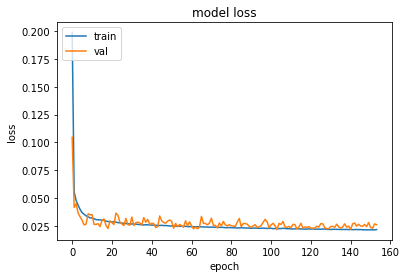

Best Epoch:104


In [9]:
##################
# REPORTS
##################
reports.plotHistory( hist )

In [10]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0100_1000-64-resnet-xxh-2\assets


C:\Users\rdelasheras\Anaconda3\envs\tf-gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [11]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Black image found
Black image found
Images count =2208
Best RMSENZ  =1895 (0.86)
Best MAENZ   =1964 (0.89)
Best PSNR    =1895 (0.86)
Best Accuracy=2017 (0.91)
RMSE-NZ  Pred=0.0290  Noisy=0.0943
MAE-NZ   Pred=0.0218  Noisy=0.0903
PSNR     Pred=18.7 dB Noisy=9.4 dB
Accuracy Pred=0.39    Noisy=0.09
SSM      Pred=0.92    Noisy=0.62
HOG MSE  Pred=0.10    Noisy=0.12


In [12]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test/
Noisy files:19
Nitid files:19
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_12_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_12_nitid_idx134.tif


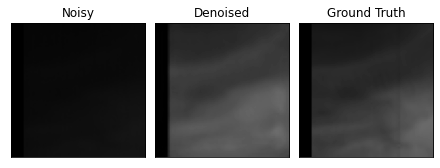

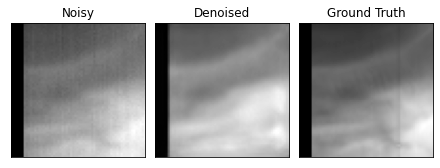

RMSE-NZ  Pred=0.0645  Noisy=0.1722 BEST
MAE-NZ   Pred=0.0588  Noisy=0.1588 BEST
PSNR     Pred=16.2 dB Noisy=7.7 dB BEST
Accuracy Pred=0.12    Noisy=0.00 BEST
SSM      Pred=0.89    Noisy=0.29
HOG MSE  Pred=0.03    Noisy=0.04
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_13_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_13_nitid_idx134.tif


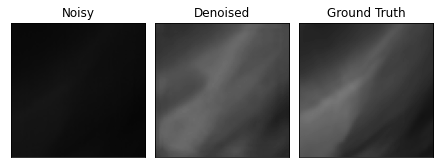

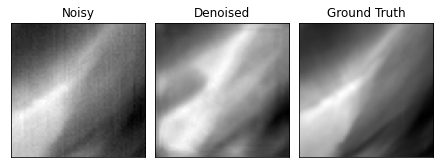

RMSE-NZ  Pred=0.0688  Noisy=0.2105 BEST
MAE-NZ   Pred=0.0643  Noisy=0.1954 BEST
PSNR     Pred=16.7 dB Noisy=6.9 dB BEST
Accuracy Pred=0.04    Noisy=0.00 BEST
SSM      Pred=0.87    Noisy=0.30
HOG MSE  Pred=0.04    Noisy=0.13
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_14_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_00_02_14_nitid_idx134.tif


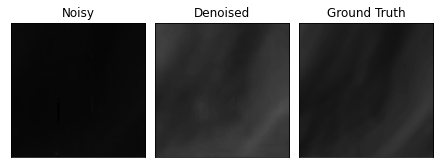

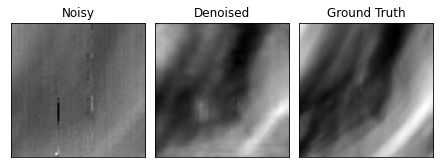

RMSE-NZ  Pred=0.0598  Noisy=0.0994 BEST
MAE-NZ   Pred=0.0586  Noisy=0.0953 BEST
PSNR     Pred=11.4 dB Noisy=7.0 dB BEST
Accuracy Pred=0.00    Noisy=0.00 WORST
SSM      Pred=0.90    Noisy=0.32
HOG MSE  Pred=0.09    Noisy=0.16
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_01_00_0_noisy_idx014.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0112_01_00_0_nitid_idx017.tif


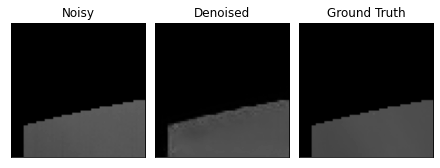

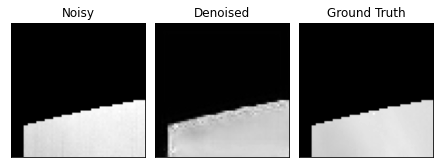

RMSE-NZ  Pred=0.0155  Noisy=0.0388 BEST
MAE-NZ   Pred=0.0080  Noisy=0.0376 BEST
PSNR     Pred=27.0 dB Noisy=19.0 dB BEST
Accuracy Pred=0.80    Noisy=0.00 BEST
SSM      Pred=0.92    Noisy=0.91
HOG MSE  Pred=0.13    Noisy=0.07
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_01_4_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_01_4_nitid_idx017.tif


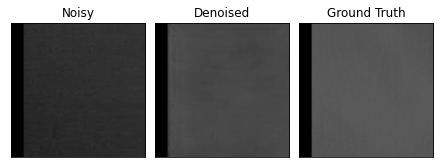

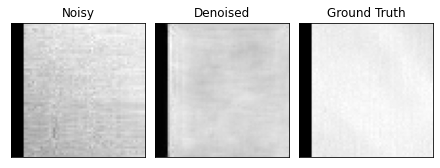

RMSE-NZ  Pred=0.0576  Noisy=0.1632 BEST
MAE-NZ   Pred=0.0539  Noisy=0.1622 BEST
PSNR     Pred=15.9 dB Noisy=6.9 dB BEST
Accuracy Pred=0.09    Noisy=0.00 BEST
SSM      Pred=0.94    Noisy=0.84
HOG MSE  Pred=0.00    Noisy=0.01
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_02_12_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0317_03_02_12_nitid_idx134.tif


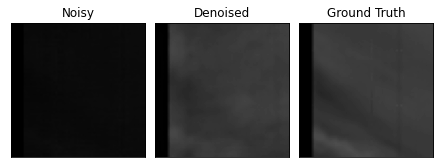

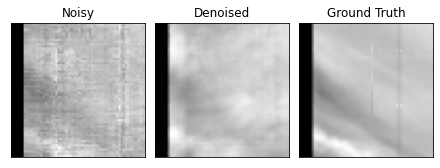

RMSE-NZ  Pred=0.0175  Noisy=0.1870 BEST
MAE-NZ   Pred=0.0130  Noisy=0.1854 BEST
PSNR     Pred=24.7 dB Noisy=4.2 dB BEST
Accuracy Pred=0.51    Noisy=0.00 BEST
SSM      Pred=0.95    Noisy=0.31
HOG MSE  Pred=0.05    Noisy=0.03
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_4_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_4_nitid_idx134.tif


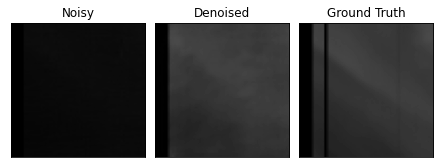

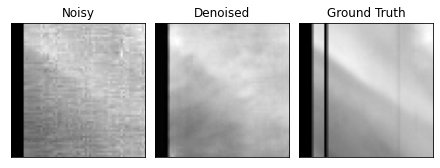

RMSE-NZ  Pred=0.0318  Noisy=0.1704 BEST
MAE-NZ   Pred=0.0141  Noisy=0.1661 BEST
PSNR     Pred=19.2 dB Noisy=4.6 dB BEST
Accuracy Pred=0.60    Noisy=0.00 BEST
SSM      Pred=0.87    Noisy=0.32
HOG MSE  Pred=0.05    Noisy=0.07
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0318_03_02_5_nitid_idx134.tif


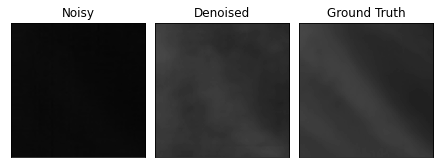

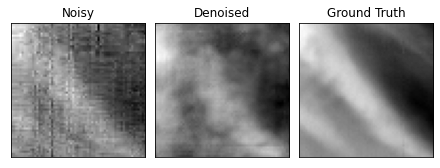

RMSE-NZ  Pred=0.0168  Noisy=0.1649 BEST
MAE-NZ   Pred=0.0139  Noisy=0.1619 BEST
PSNR     Pred=24.4 dB Noisy=4.6 dB BEST
Accuracy Pred=0.41    Noisy=0.00 BEST
SSM      Pred=0.96    Noisy=0.34
HOG MSE  Pred=0.22    Noisy=0.35
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_03_02_10_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_03_02_10_nitid_idx134.tif


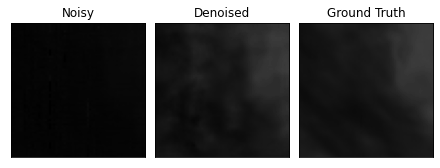

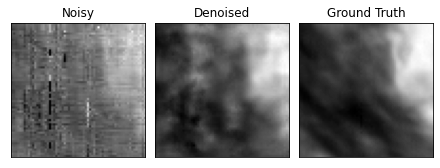

RMSE-NZ  Pred=0.0161  Noisy=0.0964 BEST
MAE-NZ   Pred=0.0128  Noisy=0.0856 BEST
PSNR     Pred=23.4 dB Noisy=7.9 dB BEST
Accuracy Pred=0.47    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.39
HOG MSE  Pred=0.07    Noisy=0.20
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_04_03_14_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0322_04_03_14_nitid_idx146.tif


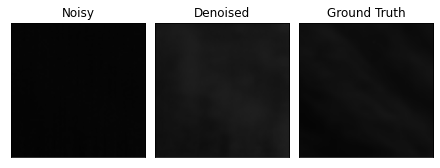

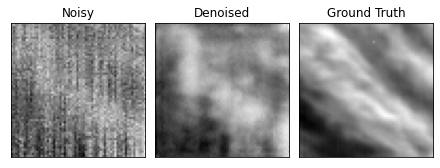

RMSE-NZ  Pred=0.0378  Noisy=0.0368 WORST
MAE-NZ   Pred=0.0365  Noisy=0.0345 WORST
PSNR     Pred=7.1 dB Noisy=7.3 dB WORST
Accuracy Pred=0.00    Noisy=0.05 WORST
SSM      Pred=0.84    Noisy=0.43
HOG MSE  Pred=0.15    Noisy=0.22
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_01_12_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_01_12_nitid_idx017.tif


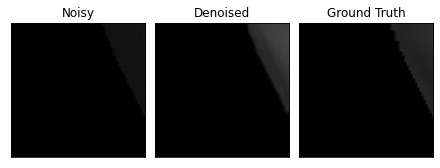

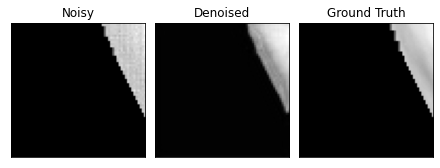

RMSE-NZ  Pred=0.0239  Noisy=0.0366 BEST
MAE-NZ   Pred=0.0100  Noisy=0.0184 BEST
PSNR     Pred=17.7 dB Noisy=14.0 dB BEST
Accuracy Pred=0.87    Noisy=0.74 BEST
SSM      Pred=0.90    Noisy=0.84
HOG MSE  Pred=0.12    Noisy=0.02
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_02_5_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0332_00_02_5_nitid_idx134.tif


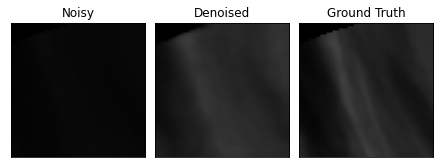

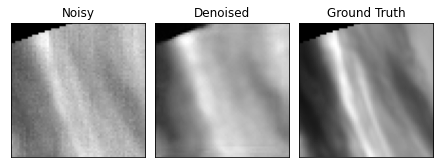

RMSE-NZ  Pred=0.0284  Noisy=0.1089 BEST
MAE-NZ   Pred=0.0249  Noisy=0.0979 BEST
PSNR     Pred=19.0 dB Noisy=7.3 dB BEST
Accuracy Pred=0.18    Noisy=0.01 BEST
SSM      Pred=0.89    Noisy=0.34
HOG MSE  Pred=0.05    Noisy=0.13
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0343_03_01_8_noisy_idx020.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0343_03_01_8_nitid_idx017.tif


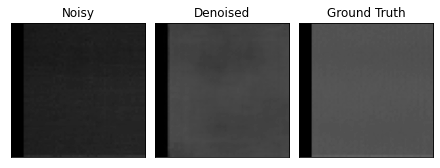

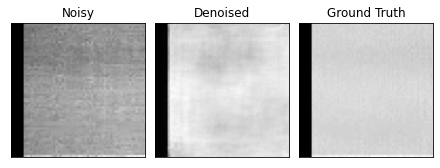

RMSE-NZ  Pred=0.0588  Noisy=0.1952 BEST
MAE-NZ   Pred=0.0544  Noisy=0.1947 BEST
PSNR     Pred=16.4 dB Noisy=6.0 dB BEST
Accuracy Pred=0.09    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.71
HOG MSE  Pred=0.01    Noisy=0.02
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_11_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_11_nitid_idx134.tif


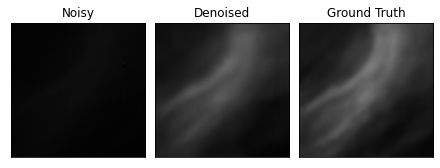

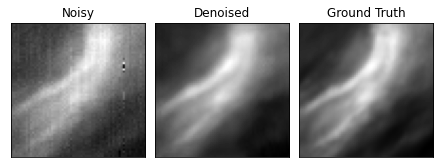

RMSE-NZ  Pred=0.0433  Noisy=0.1931 BEST
MAE-NZ   Pred=0.0360  Noisy=0.1660 BEST
PSNR     Pred=21.0 dB Noisy=8.0 dB BEST
Accuracy Pred=0.11    Noisy=0.00 BEST
SSM      Pred=0.92    Noisy=0.33
HOG MSE  Pred=0.03    Noisy=0.09
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_12_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_12_nitid_idx134.tif


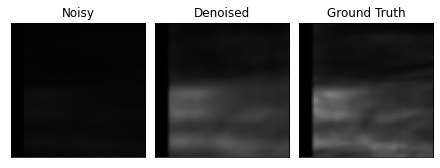

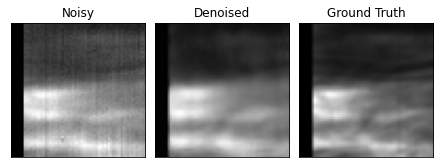

RMSE-NZ  Pred=0.0288  Noisy=0.1742 BEST
MAE-NZ   Pred=0.0198  Noisy=0.1438 BEST
PSNR     Pred=24.7 dB Noisy=9.1 dB BEST
Accuracy Pred=0.41    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.38
HOG MSE  Pred=0.02    Noisy=0.05
******************************************************
Index:15
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_13_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_02_13_nitid_idx134.tif


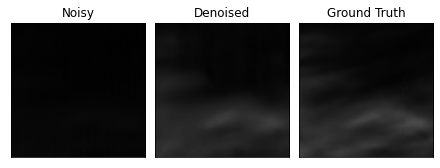

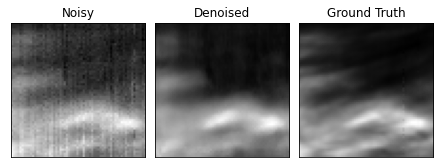

RMSE-NZ  Pred=0.0176  Noisy=0.0979 BEST
MAE-NZ   Pred=0.0128  Noisy=0.0772 BEST
PSNR     Pred=24.3 dB Noisy=9.4 dB BEST
Accuracy Pred=0.54    Noisy=0.04 BEST
SSM      Pred=0.95    Noisy=0.50
HOG MSE  Pred=0.04    Noisy=0.12
******************************************************
Index:16
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_11_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_11_nitid_idx146.tif


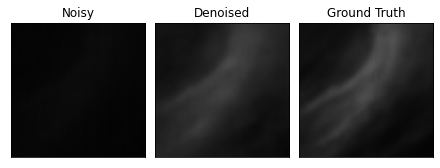

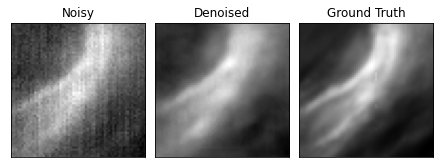

RMSE-NZ  Pred=0.0222  Noisy=0.1221 BEST
MAE-NZ   Pred=0.0175  Noisy=0.1019 BEST
PSNR     Pred=23.6 dB Noisy=8.8 dB BEST
Accuracy Pred=0.36    Noisy=0.02 BEST
SSM      Pred=0.93    Noisy=0.38
HOG MSE  Pred=0.04    Noisy=0.14
******************************************************
Index:17
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_8_noisy_idx157.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_01_03_8_nitid_idx146.tif


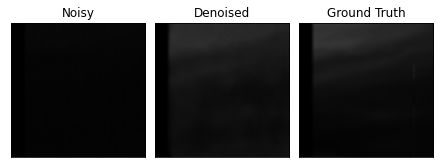

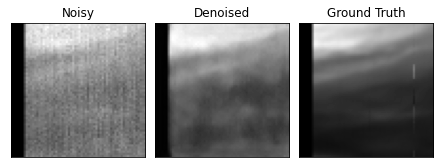

RMSE-NZ  Pred=0.0202  Noisy=0.0710 BEST
MAE-NZ   Pred=0.0166  Noisy=0.0512 BEST
PSNR     Pred=20.9 dB Noisy=10.0 dB BEST
Accuracy Pred=0.34    Noisy=0.21 BEST
SSM      Pred=0.88    Noisy=0.47
HOG MSE  Pred=0.07    Noisy=0.10
******************************************************
Index:18
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_05_02_0_noisy_idx123.tif
C:/Projects/VenusDenoise/dataset/cases/64/0100_1000/test\VI0379_05_02_0_nitid_idx134.tif


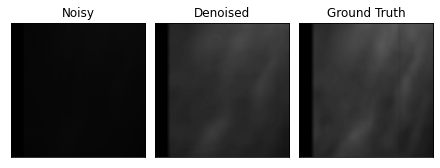

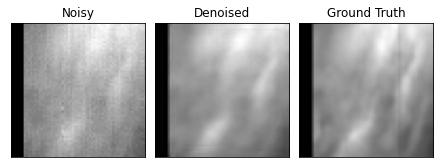

RMSE-NZ  Pred=0.0307  Noisy=0.1835 BEST
MAE-NZ   Pred=0.0270  Noisy=0.1780 BEST
PSNR     Pred=21.0 dB Noisy=5.5 dB BEST
Accuracy Pred=0.16    Noisy=0.00 BEST
SSM      Pred=0.95    Noisy=0.30
HOG MSE  Pred=0.02    Noisy=0.03
******************************************************


In [13]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
    dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
    dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )